# Kernelized Neural Process

Last Update : 13 June 2019

In [1]:
N_THREADS = 8
# Nota Bene : notebooks don't deallocate GPU memory
IS_FORCE_CPU = False # can also be set in the trainer

## Environment

In [2]:
cd ..

/master


In [3]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# CENTER PLOTS
from IPython.core.display import HTML
display(HTML(""" <style> .output_png {display: table-cell; text-align: center; margin:auto; }
.prompt display:none;}  </style>"""))

import os
if IS_FORCE_CPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = ""

import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(N_THREADS)

Autosaving every 600 seconds


## Dataset

In this notebook I only look at the periodic and mattern kernel. See [Tutorial 1 - Conditional Neural Process] for more details.

[Tutorial 1 - Conditional Neural Process]: Tutorial%201%20-%20Conditional%20Neural%20Process.ipynb

In [4]:
from sklearn.gaussian_process.kernels import RBF, Matern, ExpSineSquared, DotProduct, ConstantKernel
from ntbks_viz import plot_posterior_samples, plot_prior_samples, plot_dataset_samples

from ntbks_datasets import GPDataset

In [5]:
X_DIM = 1  # 1D spatial input
Y_DIM = 1  # 1D regression
N_POINTS = 128
N_SAMPLES = 100000 # this is a lot and can work with less

In [6]:
datasets = dict()
kwargs = dict(n_samples=N_SAMPLES, n_points=N_POINTS)
datasets["rbf"] = GPDataset(kernel=1.0 * RBF(length_scale=1.0,
                                             length_scale_bounds=(1e-1, 10.0)),
                            **kwargs)

datasets["periodic"] = GPDataset(kernel=1.0 * ExpSineSquared(length_scale=1.0,
                                                             periodicity=3.0,
                                                             length_scale_bounds=(0.1, 10.0),
                                                             periodicity_bounds=(1.0, 10.0)),
                                 **kwargs)
datasets["non-stationary"] = GPDataset(kernel=(ConstantKernel(0.1, (0.01, 10.0)) *
                                               (DotProduct(sigma_0=1.0,
                                                           sigma_0_bounds=(0.1, 10.0)) ** 2)),
                                       **kwargs)
datasets["matern"] = GPDataset(kernel=1.0 * Matern(length_scale=1.0,
                                                   length_scale_bounds=(1e-1, 10.0),
                                                   nu=1.5),
                               **kwargs)

## Model


In [7]:
from torch.distributions import Normal

from skssl.transformers import (NeuralProcessLoss, NeuralProcess, AttentiveNeuralProcess, 
                                SelfAttentionBlock, SinusoidalEncodings, FeatureEncodings)
from skssl.predefined import MLP, merge_flat_input, get_uninitialized_mlp
from skssl.transformers.neuralproc.datasplit import context_target_split

In [8]:
R_DIM = 128
RANGE_CNTXT = (4, 50)  # context points will be sampled uniformly in this range
RANGE_EXTRA_TRGTS = (3, N_POINTS-RANGE_CNTXT[1])  # extra number of targtes points 

In [9]:
def get_cntxt_trgt(*args):
    return context_target_split(*args, range_cntxts=RANGE_CNTXT, range_extra_trgts=RANGE_EXTRA_TRGTS)

def init_model():
    return AttentiveNeuralProcess(X_DIM, Y_DIM,
                         XEncoder=FeatureEncodings, 
                         XYEncoder=merge_flat_input(get_uninitialized_mlp(n_hidden_layers=2),
                                                    is_sum_merge=False),  
                         Decoder=merge_flat_input(get_uninitialized_mlp(n_hidden_layers=4),
                                                  is_sum_merge=False),  # no self attention encoder 
                         r_dim=R_DIM,
                         get_cntxt_trgt=get_cntxt_trgt,
                         aggregator=torch.mean,
                         PredictiveDistribution=Normal, 
                         LatentEncoder=MLP,
                         x_transf_dim=8,
                          attention="weighted_dist", # parameter free attention because simple task
                          encoded_path="deterministic", # use both latent  and deterministic path as in paper
                         is_normalize=False)

In [10]:
# initialize one model for each dataset
data_models = {name: (init_model(), data) 
               for name, data in datasets.items()}

### N Param

Number of parameters (note that I did not play around with this much, this depends a lot on the representation size):

In [11]:
from utils.helpers import count_parameters

In [12]:
for k, (neural_proc, dataset) in data_models.items():
    print("N Param:", count_parameters(neural_proc))
    break

N Param: 13333


The increase of parameters doesn't come from attention (as the attention is parameter free in this case), but from the fact that we have a deterministic and a latent path. Using only a deterministic path, the model can be very small. See the following notebook to see such a model with only 35682 parameters : [Small Multihead Conditional Attentive Neural Process]

[Small Multihead Conditional Attentive Neural Process]: Small%20Multihead%20Conditional%20Attentive%20Neural%20Process.ipynb

## Training

In [13]:
from skorch.callbacks import ProgressBar, Checkpoint

from skssl.training import NeuralNetTransformer
from skssl.training.helpers import make_Xy_input

Nota Bene: using a small batch size is probably important as we use fix amount of context in batch, and with attention you don't have aggregation => the number of context points changes the attention mechanism (the softmax) => use small to have many different number of context points but we want a fair comparison so keep `learning rate=1e-3` and `batch_size=64` like other notebook.

In [14]:
N_EPOCHS = 30 # 30 is enough
BATCH_SIZE = 64 
is_RETRAIN = True # if false load precomputed

In [15]:
for k,(neural_proc, dataset) in data_models.items():
    print()
    print("--- {} {} ---".format("Training" if is_RETRAIN else "Loading", k))
    print()
    
    chckpt = Checkpoint(dirname="results/notebooks/neural_process/kcnp_{}".format(k), 
                        monitor='train_loss_best') # train would be same as validation as always resamples
    
    model = NeuralNetTransformer(neural_proc, NeuralProcessLoss,
                                 max_epochs=N_EPOCHS,
                                 batch_size=BATCH_SIZE,
                                 train_split=None,  # don't use cross validation dev set
                                 lr=1e-3, # they use 5e-5 because 16 batch size but that would be slow
                                 callbacks=[ProgressBar(), 
                                            chckpt], # checkpoint best model
                                ) 
    
    if is_RETRAIN:
        _=model.fit(*make_Xy_input(dataset))
    
    # load in all case => even when training loads the best checkpoint
    model.initialize()
    model.load_params(checkpoint=chckpt)


--- Training rbf ---



  epoch    train_loss    cp      dur
-------  ------------  ----  -------
      1     4231.6132     +  20.1690


      2      275.6089     +  22.0749


      3      304.1946        22.9964


      4      190.7013     +  22.6768


      5      180.7734     +  23.3415


      6      329.2734        22.2497


      7      563.6282        22.8268


      8      160.9032     +  22.9203


      9      154.2716     +  22.9942


     10      152.7729     +  23.0432


     11      144.6588     +  22.9828


     12      134.1092     +  22.8814


     13      120.2518     +  23.2146


     14      109.8854     +  22.3289


     15      101.7003     +  23.0777


     16       92.0160     +  22.9094


     17       85.6739     +  23.0685


     18       81.2351     +  22.7669


     19       76.9015     +  23.0420


     20       72.8081     +  23.0471


     21       68.0243     +  22.1470


     22       65.6672     +  22.1315


     23       62.4277     +  22.1712


     24       59.9179     +  22.7434


     25       55.8957     +  23.4171


     26       55.4435     +  22.6776


     27       53.1108     +  22.2980


     28       53.1915        22.4452


     29       51.6304     +  22.4422


     30       48.2108     +  23.2227
Re-initializing optimizer because the following parameters were re-set: .

--- Training periodic ---



  epoch    train_loss    cp      dur
-------  ------------  ----  -------
      1      221.0099     +  22.6184


      2      135.3451     +  21.7846


      3      131.0194     +  23.0584


      4      128.8371     +  23.1474


      5      126.5950     +  22.5462


      6      125.9311     +  23.1981


      7      124.5613     +  22.8317


      8      123.2487     +  22.2854


      9      120.0046     +  23.7136


     10      109.4710     +  22.6660


     11       96.7411     +  23.0741


     12       82.9136     +  22.4931


     13       77.7684     +  22.5894


     14       74.4388     +  22.4502


     15       71.7675     +  22.6448


     16       68.8653     +  23.0426


     17       66.9980     +  22.7783


     18       65.2930     +  23.4504


     19       64.1715     +  23.3592


     20       62.2385     +  22.4576


     21       62.5391        23.0797


     22       60.0903     +  19.5381


     23       58.3958     +  16.3614


Re-initializing optimizer because the following parameters were re-set: .

--- Training non-stationary ---



Re-initializing optimizer because the following parameters were re-set: .

--- Training matern ---



Re-initializing optimizer because the following parameters were re-set: .


# Trained Prior

In [19]:
EXTRAP_DISTANCE = 2  # add 2 to the right for extrapolation
INTERPOLATION_RANGE = dataset.min_max
EXTRAPOLATION_RANGE = (dataset.min_max[0], dataset.min_max[1]+EXTRAP_DISTANCE )

std: 1.296997998654842
std: 0.31305646941065784
std: 33.79551175013185
std: 0.4012288692593573


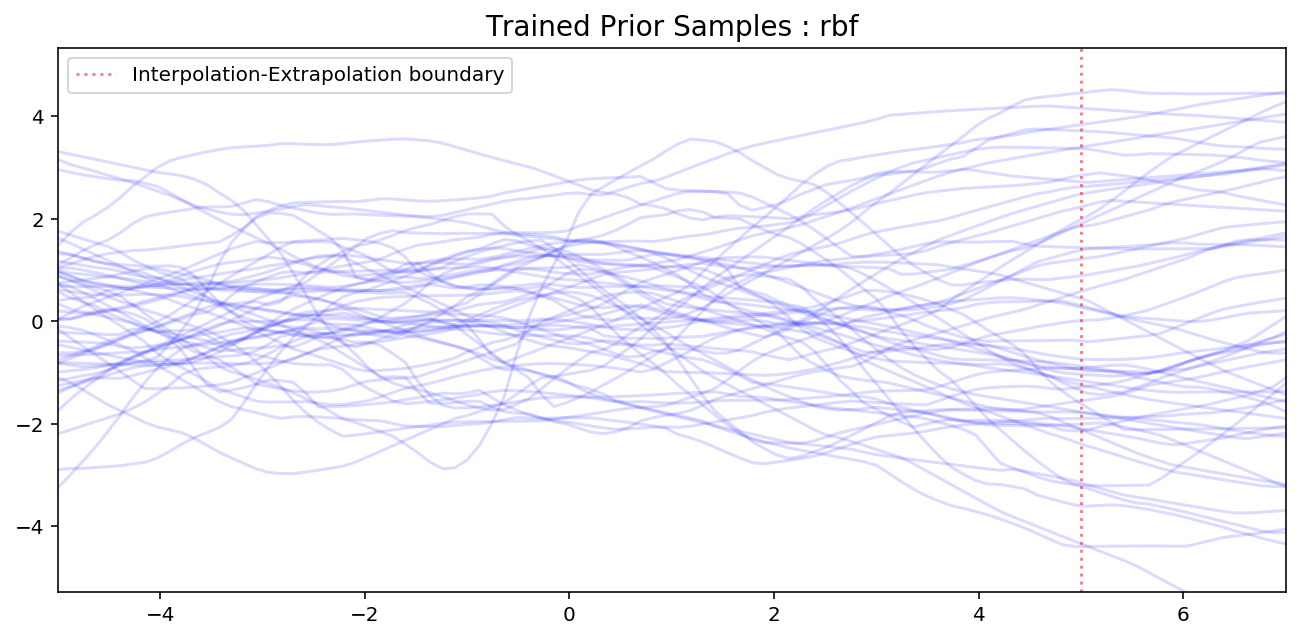

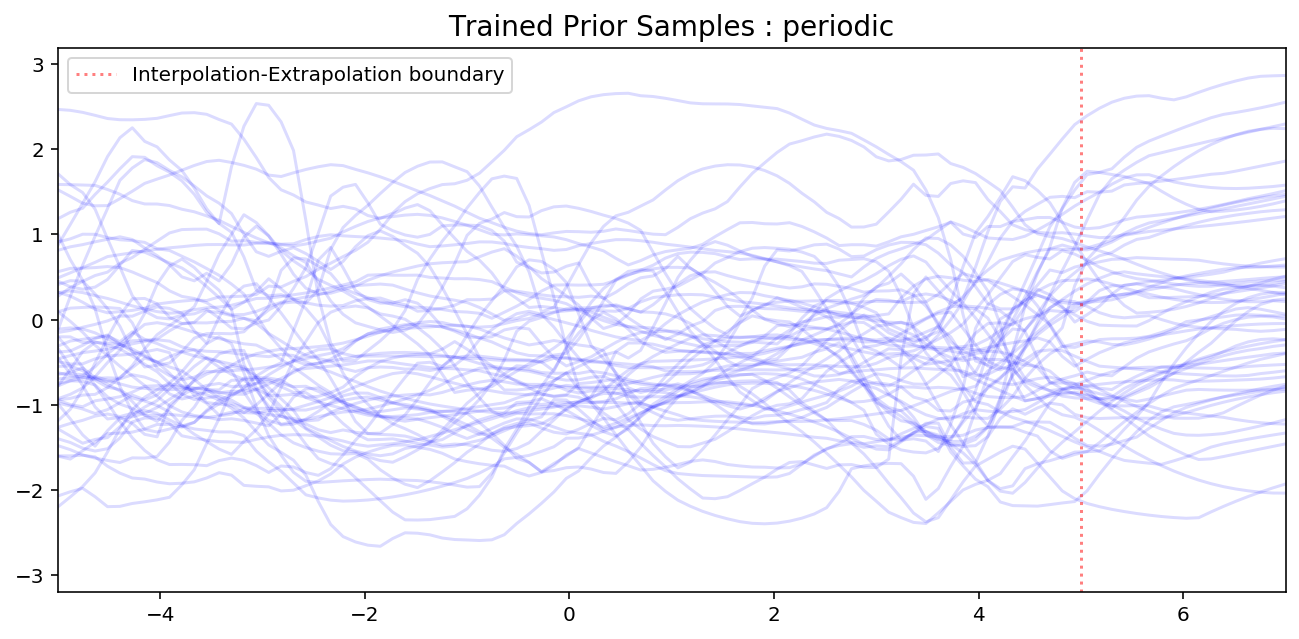

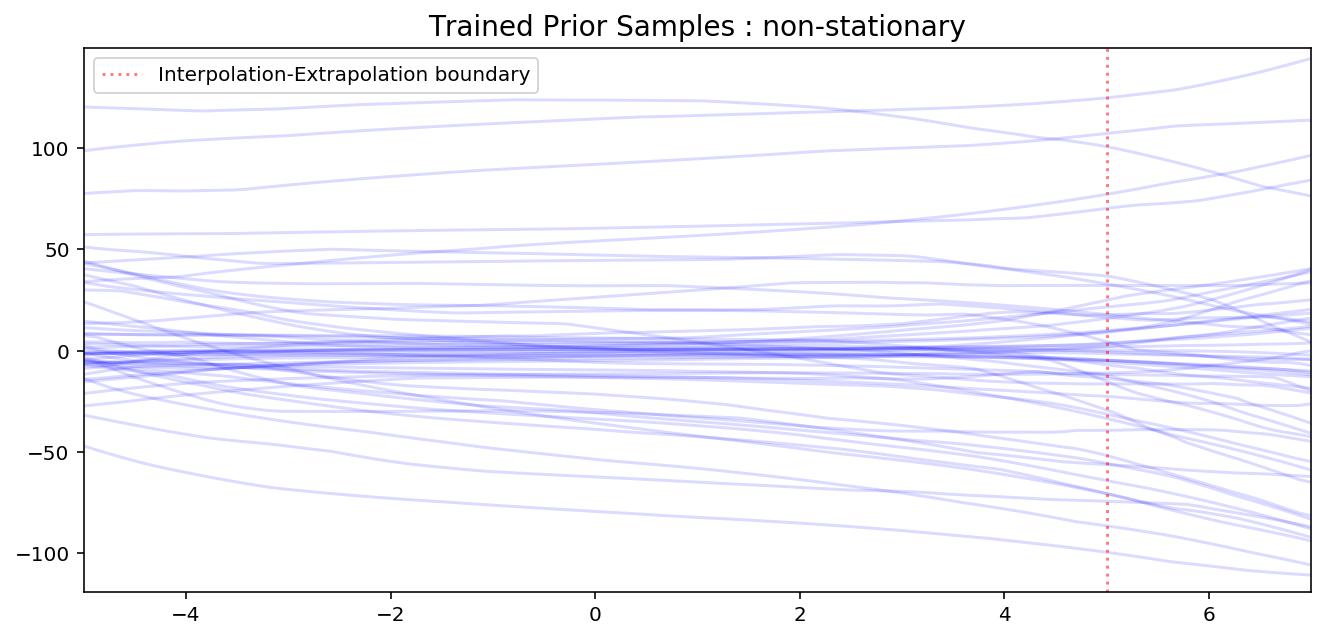

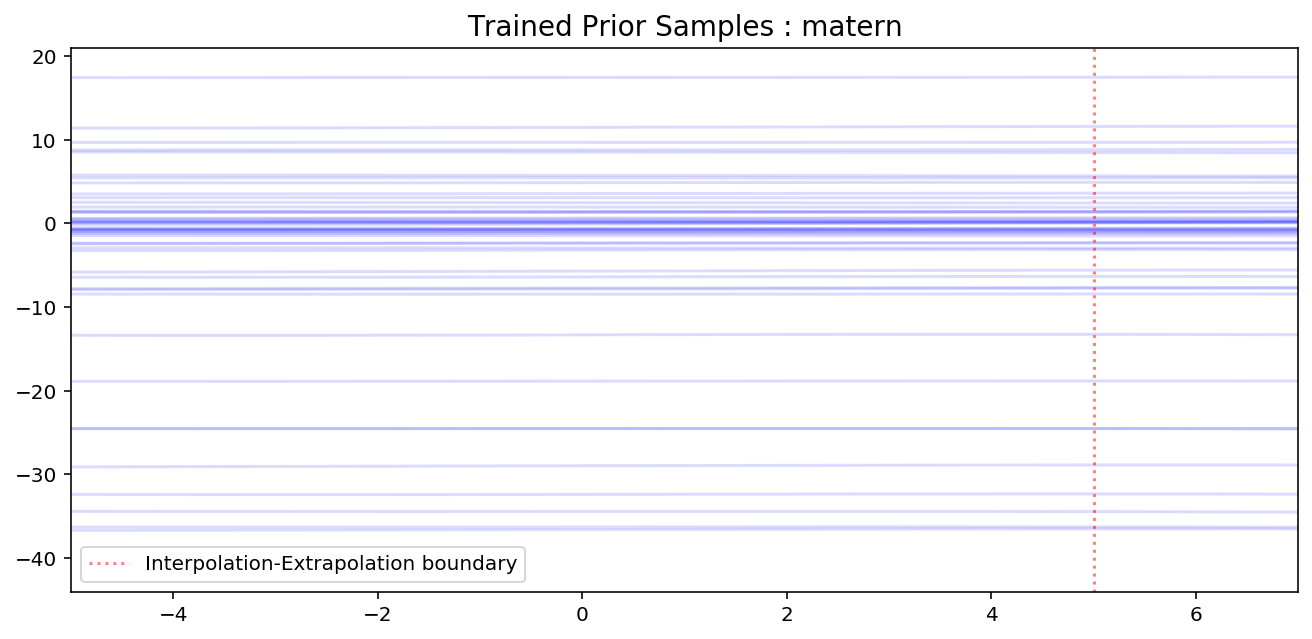

In [20]:
for k,(neural_proc, dataset) in data_models.items():
    plot_prior_samples(neural_proc, 
                       title="Trained Prior Samples : {}".format(k), 
                       test_min_max=EXTRAPOLATION_RANGE, 
                       train_min_max=INTERPOLATION_RANGE)

# Posterior

std: 0.6630878448486326
std: 0.45214819908142045
std: 7042.013183593745
std: 0.10000001639127731


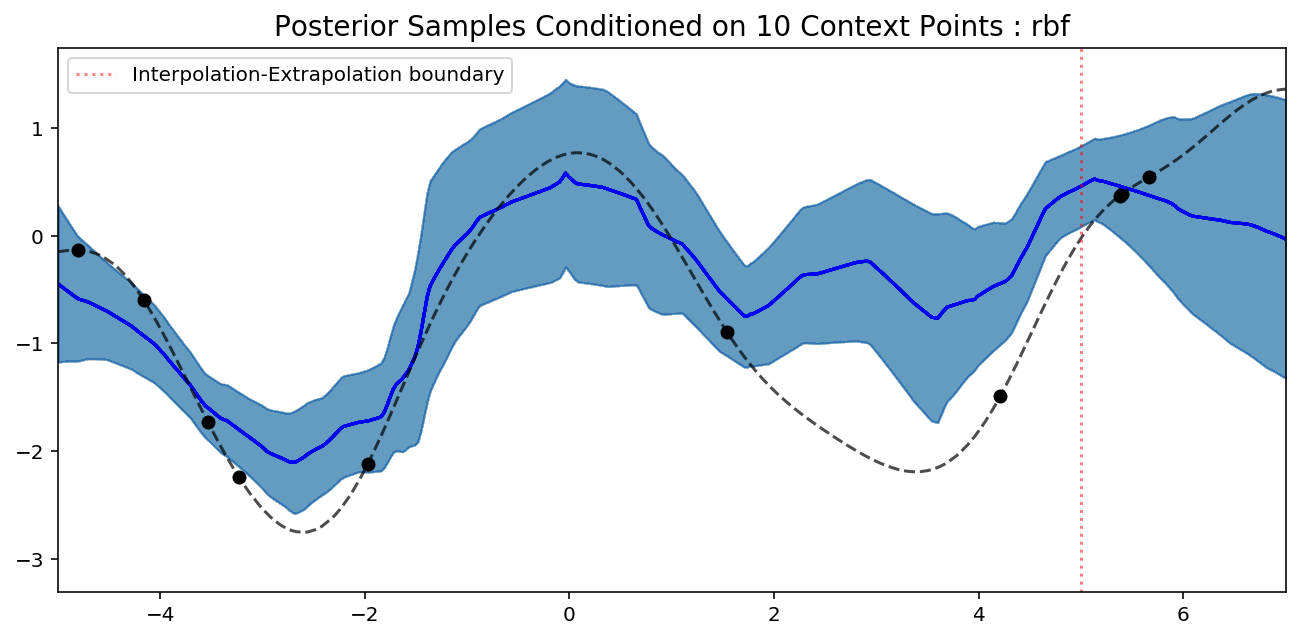

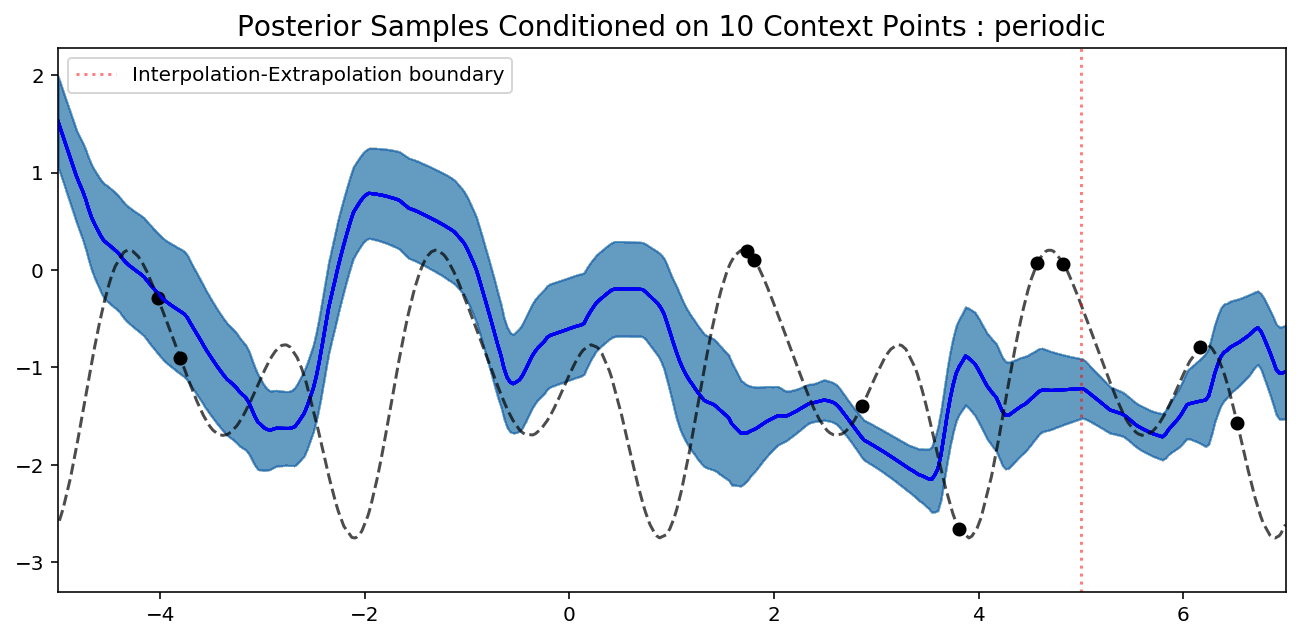

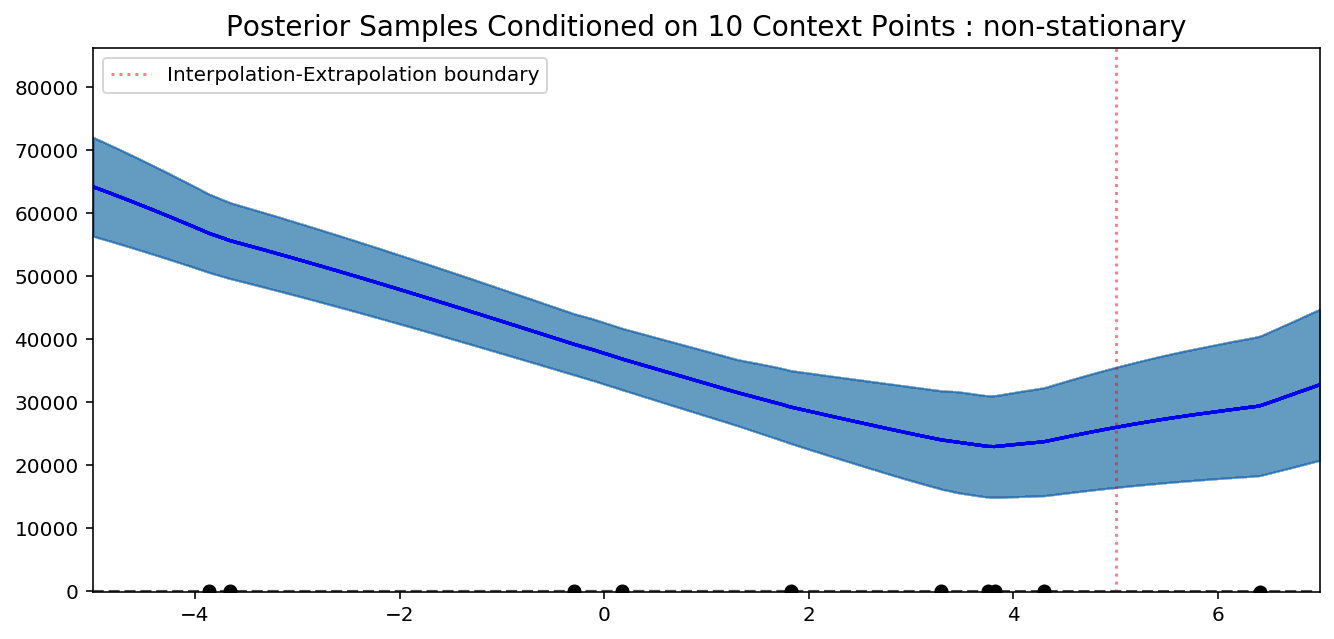

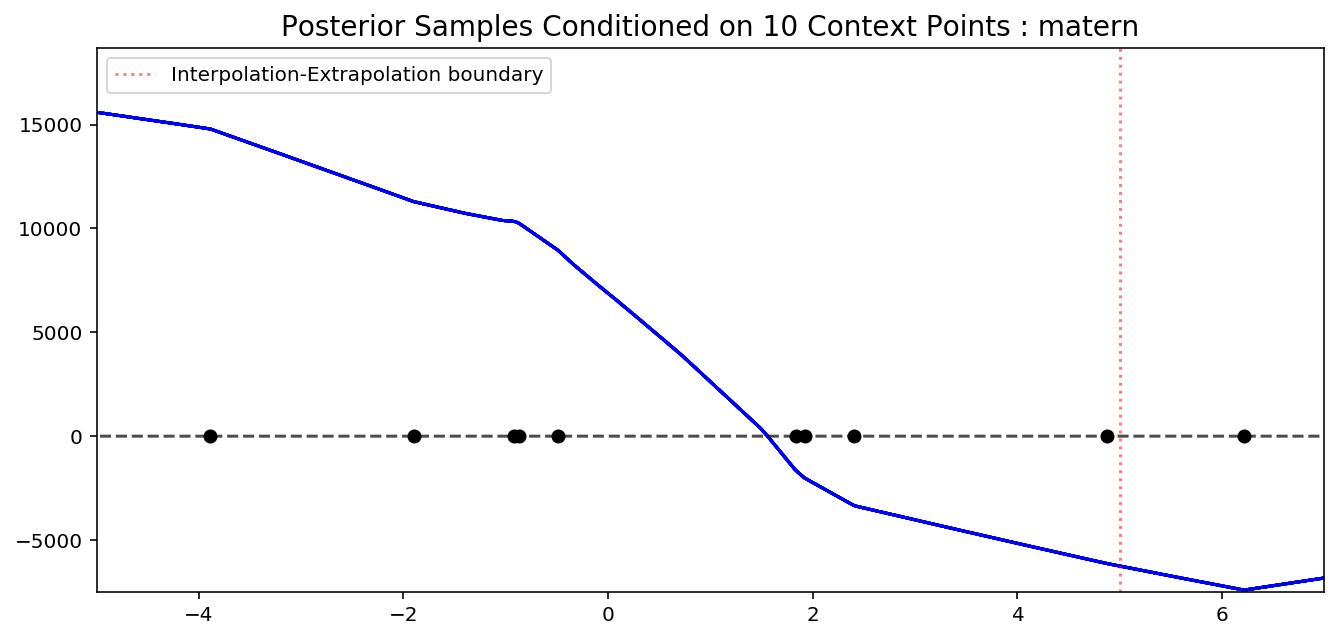

In [21]:
N_CNTXT = 10
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=400,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

In [ ]:
N_CNTXT = 2
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=2*N_POINTS,
                           n_samples=30,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

In [ ]:
N_CNTXT = 20
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=2*N_POINTS,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

In [ ]:
N_CNTXT = 1
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=2*N_POINTS,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

We see that the predictions are much better than in [Tutorial 2 - Neural Process]

**Good**:
- the sampled function all go through or close to the context points
- the uncertainty decreases close to context points
- the samples all seem relatively different (not linear shifts like in [Tutorial 2 - Neural Process])

**Bad**:
- there seems to always be a strange "jump" in the middle of region between 2 far points. This is probably due to the softmax in cross attention, and disappears when using multihead attention. 
- cannot extrapolate and not even give high uncertainty when extrapolating

[Tutorial 2 - Neural Process]: Tutorial%202%20-%20Neural%20Process.ipynb